# LangChain

 - 텍스트에서 SQL을 뽑아서 데이터베이스에 실행하고 결과를 가져온다.
 - 외부의 Webhook, API 를 호출
 - 여러 모델에서 결과를 가져오거나 모델을 연결해서 순서대로 실행

이런 시나리오가 필요할 때 LangChain. Components, Agents
[Text](https://python.langchain.com/docs/integrations/llms/google_vertex_ai_palm), [Chat](https://python.langchain.com/docs/integrations/chat/google_vertex_ai_palm), and [Embeddings](https://python.langchain.com/docs/integrations/text_embedding/google_vertex_ai_palm) 모델이 LangChain Python SDK와 통합됨.

In [4]:
!pip install google-cloud-aiplatform chromadb pydantic typing-inspect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.4/422.4 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.0/321.0 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 94.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml

In [5]:
!pip install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.6 MB/s eta 0:00:00


In [6]:
# Automatically restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [2]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [3]:
import vertexai

PROJECT_ID = "genai-learning-768"
vertexai.init(project=PROJECT_ID, location="us-central1")


In [4]:
import time
from typing import List

import langchain
from pydantic import BaseModel

print(f"LangChain Version: {langchain.__version__}")

LangChain Version: 0.0.287


In [5]:
# vertext AI
from google.cloud import aiplatform
from langchain.chat_models.vertexai import ChatVertexAI
from langchain.embeddings import VertexAIEmbeddings
from langchain.llms import VertexAI
from langchain.schema import HumanMessage, SystemMessage

print(f"Vertext AI SDK version: {aiplatform.__version__}")

Vertext AI SDK version: 1.32.0


In [6]:
# Utility functions for Embeddings API with rate limiting
def rate_limit(max_per_minute):
    period = 60 / max_per_minute
    print("Waiting")
    while True:
        before = time.time()
        yield
        after = time.time()
        elapsed = after - before
        sleep_time = max(0, period - elapsed)
        if sleep_time > 0:
            print(".", end="")
            time.sleep(sleep_time)


class CustomVertexAIEmbeddings(VertexAIEmbeddings, BaseModel):
    requests_per_minute: int
    num_instances_per_batch: int

    # Overriding embed_documents method
    def embed_documents(self, texts: List[str]):
        limiter = rate_limit(self.requests_per_minute)
        results = []
        docs = list(texts)

        while docs:
            # Working in batches because the API accepts maximum 5
            # documents per request to get embeddings
            head, docs = (
                docs[: self.num_instances_per_batch],
                docs[self.num_instances_per_batch :],
            )
            chunk = self.client.get_embeddings(head)
            results.extend(chunk)
            next(limiter)

        return [r.values for r in results]

**Define LangChain Models using Vertex AI PaLM API for Text, Chat and Vertex AI Embedding for Text**

In [7]:
# LLM model
llm = VertexAI(
    model_name="text-bison@001",
    max_output_tokens=256,
    temperature=0.1,
    top_p=0.8,
    top_k=40,
    verbose=True,
)

# Chat
chat = ChatVertexAI()

# Embedding
EMBEDDING_QPM = 100
EMBEDDING_NUM_BATCH = 5
embeddings = CustomVertexAIEmbeddings(
    requests_per_minute=EMBEDDING_QPM,
    num_instances_per_batch=EMBEDDING_NUM_BATCH,
)

# Text

In [ ]:
prompt = "월요일 다음에 무슨요일?"
llm(prompt)

'월요일 다음은 화요일입니다. 화요일은 월요일 다음에 오는 요일입니다. 화요일은 2월 22일, 3월 22일, 4월 22일, 5월 22일, 6월 22일, 7월 22일, 8월 22일, 9월 22일, 10월 22일, 11월 22일, 12월 22일에 있습니다.'

# Chat

In [ ]:
chat([HumanMessage(content="안녕하세요. 잘 지내셨죠?")])

AIMessage(content=' 안녕하세요! 잘 지내고 있습니다. 물어봐 주셔서 감사합니다. 사람들의 작업과 창의적인 프로젝트를 도울 수 있게 되어 기쁩니다. 오늘은 어떠세요?', additional_kwargs={}, example=False)

In [ ]:
res = chat([
    SystemMessage(content="너는 사람들이 무엇을 먹고싶어하는지 메시지를 읽고 알 수 있는 굉장한 AI 봇이야"),
    HumanMessage(content="나는 토마토를 좋아해. 뭘 먹을까?")
])
print(res.content)

 토마토를 좋아하시군요. 토마토를 곁들인 요리로는 다음과 같은 것들이 있습니다.

* 토마토 수프
* 토마토 파스타
* 토마토 샐러드
* 토마토 샌드위치
* 토마토 오믈렛
* 토마토 피자
* 토마토 리조또
* 토마토 카레
* 토마토 스튜
* 토마토 칠리


In [ ]:
res = chat([
    HumanMessage(content="토마토 카레의 재료는 뭘까?")
])
print(res.content)

 토마토 카레의 재료는 다음과 같습니다.

* 토마토 1kg
* 양파 1개
* 마늘 2쪽
* 생강 1조각
* 고춧가루 1큰술
* 강황가루 1작은술
* 커민가루 1작은술
* 고수가루 1작은술
* 소금 1작은술
* 설탕 1작은술
* 식용유 2큰술
* 물 1컵


# Document

In [8]:
from langchain.schema import Document
Document(
    page_content="LangChain의 기본 기능을 설명하는 문서.",
    metadata = {
        "doc_id": 13452,
        "doc_source": "LangChain 온라인 문서",
        "doc_create_time": 1680013019
    }
)

Document(page_content='LangChain의 기본 기능을 설명하는 문서.', metadata={'doc_id': 13452, 'doc_source': 'LangChain 온라인 문서', 'doc_create_time': 1680013019})

## Embedding

In [9]:
text = "안녕! 이제 우리 사귀자."

text_embedding = embeddings.embed_query(text)
print(f"Embedding length: {len(text_embedding)}")
print(f"Here's a sample: {text_embedding[:5]}...")

Embedding length: 768
Here's a sample: [-0.023133451119065285, 0.023635217919945717, -0.0035285213962197304, 0.05833696946501732, 0.09647057205438614]...


## Prompt Template

In [13]:
from langchain import PromptTemplate

prompt_template = """
나는 {location}로 여행가고 싶어. 어떻게 해야 할까?
간단하게 얘기해줘.
"""

prompt = PromptTemplate(input_variables=["location"], template=prompt_template)

final_prompt = prompt.format(location="로마")

print(f"프롬프트: {final_prompt}")
print("-------")
print(f"LLM output: {llm(final_prompt)}")

프롬프트: 
나는 로마로 여행가고 싶어. 어떻게 해야 할까?
간단하게 얘기해줘.

-------
LLM output: 로마로 여행을 가고 싶다면, 먼저 비행기표를 예약해야 합니다. 로마에는 여러 공항이 있지만, 대부분의 사람들은 피우미치노 공항을 이용합니다. 비행기표는 온라인으로 예약할 수 있으며, 가격은 출발지와 여행 기간에 따라 다릅니다.

비행기표를 예약한 후에는 숙소를 예약해야 합니다. 로마에는 다양한 숙박 시설이 있지만, 대부분의 사람들은 호텔을 이용합니다. 호텔은 온라인으로 예약할 수 있으며, 가격은 숙박 기간과 숙소의 위치에 따라 다릅니다.

숙소를 예약한 후에는 여행 일정을 짜야 합니다. 로마에는 볼거리와 즐길 거리가 많기 때문에, 여행 일정을 짜는 데 시간이 걸릴 수 있습니다. 여행 일정을 짜는 데 도움이 필요하면, 온라인에서 다양한 여행 일정을 찾아볼 수 있습니다.

여행 일정을 짜고 나면, 로마로 여행을 떠날 준비가 된 것입니다. 로마는 아름다운 도시이며, 다양한 볼거리와 즐길 거리가 있기 때문에,


## Example Selector

In [17]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 31.3 MB/s eta 0:00:00


In [19]:
from langchain.prompts import example_selector
from langchain.prompts import FewShotPromptTemplate, PromptTemplate
from langchain.prompts.example_selector import SemanticSimilarityExampleSelector
from langchain.vectorstores import FAISS

example_prompt = PromptTemplate(
    input_variables=["input", "output"],
    template="예시 입력: {input}\n 예시 출력: {output}"
)

examples = [
    {"input": "해적", "output": "배"},
    {"input": "조종사", "output": "비행기"},
    {"input": "운전자", "output": "차"},
    {"input": "나무", "output": "땅"},
    {"input": "새", "output": "둥지"},
]

example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples,
    embeddings,
    FAISS,
    k=2
)

similar_prompt = FewShotPromptTemplate(
    example_selector=example_selector,
    example_prompt=example_prompt,
    prefix="너를 찾을 수 있는 위치를 알려줘.",
    suffix="입력: {noun}\n출력:",
    input_variables=["noun"]
)

test_noun="학생"

print(similar_prompt.format(noun=test_noun))
llm(similar_prompt.format(noun=test_noun))

Waiting
너를 찾을 수 있는 위치를 알려줘.

예시 입력: 해적
 예시 출력: 배

예시 입력: 조종사
 예시 출력: 비행기

입력: 학생
출력:


'학교'

## Output Parsers

In [20]:
from langchain.output_parsers import ResponseSchema, StructuredOutputParser

response_schemas = [
    ResponseSchema(name="bad_string", description="포멧이 없는 사용자 입력"),
    ResponseSchema(name="good_string", description="다시 포멧된 응답")
]

output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

format_instructions = output_parser.get_format_instructions()
print(format_instructions)

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"bad_string": string  // 포멧이 없는 사용자 입력
	"good_string": string  // 다시 포멧된 응답
}
```


In [22]:
template = """
사용자가 포멧이 없는 텍스트를 입력할꺼야.
다시 포멧으로 만들고 나라, 도시 등 모든 단어의 잘못 된 점을 고쳐줘.

{format_instructions}

% 사용자 입력:
{user_input}

응답:
"""

prompt = PromptTemplate(
    input_variables=["user_input"],
    partial_variables={"format_instructions": format_instructions},
    template=template
)

promptValue = prompt.format(user_input="대하민국 서울에 온것을 환영합니다. ")
print(promptValue)

llm_output = llm(promptValue)
llm_output
output_parser.parse(llm_output)


사용자가 포멧이 없는 텍스트를 입력할꺼야.
다시 포멧으로 만들고 나라, 도시 등 모든 단어의 잘못 된 점을 고쳐줘. 

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"bad_string": string  // 포멧이 없는 사용자 입력
	"good_string": string  // 다시 포멧된 응답
}
```

% 사용자 입력: 
대하민국 서울에 온것을 환영합니다. 

응답:



{'bad_string': '대하민국 서울에 온것을 환영합니다.', 'good_string': '대한민국 서울에 온 것을 환영합니다.'}

## indexs

한글을 지원하지 못하는 듯 ...

In [26]:
from langchain.document_loaders import WebBaseLoader
loader = WebBaseLoader("https://namu.wiki/w/%EC%96%91%EC%9E%90%EC%BB%B4%ED%93%A8%ED%84%B0")
data = loader.load()

print(f"{len(data)}")
print(f"샘플: \n{''.join([x.page_content[:150] for x in data[:2]])}")

1
샘플: 
Just a moment...Enable JavaScript and cookies to continue


## Text Splitters

LLM은 토큰 제한이 있기 때문에 텍스트를 chunk로 나눈다. 웹 페이지의 본문 만이 아니라 다 가져와서 잘라버리네

In [31]:
from langchain import text_splitter
from langchain.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

loader = WebBaseLoader("https://horizon.kias.re.kr/5201/")
pg_work = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)

texts = text_splitter.split_documents(pg_work)

print(f"{len(texts)}개의 문서")
print("preview: ")
print(texts[0].page_content, "\n")
print(texts[1].page_content, "\n")

23개의 문서
preview: 
믿기 힘든 양자 Incredible Quantum [1]: 들어가며 – 고등과학원 HORIZON

































 
















×
 




로그인


회원가입




Mathematics
Natural Sciences
Transdisciplinary
Archives

All Articles
과학의 지평


 



Follow Horizon






Facebook










Naver Blog








Newsletter














Please leave this field empty
Newsletter


Horizon 뉴스레터 신청

		뉴스레터 구독 신청을 하시면
 Horizon의 최신기사를 이메일로 만나보실 수 있습니다.






지난
 뉴스레터 보기


구독 신청 확인을 위해 신청하신 메일의 수신함을 확인해 주세요.
 



About HORIZON
KIAS
 
























Home
About Horizon



































 









 





Mathematics
Natural Sciences
Transdisciplinary
Archives

All Articles
과학의 지평


 




 






 















Mathematics
Natural Sciences
Transdisciplinary
Archives

All Articles
과학의 지평


 


























열린 강의실


믿기 힘든 양자 Incredible Quantum [1]: 들어가며 
2018년 2월 1일
 
							박권							













셀루








			17954,17916	
			






 

박권 

박권

전)HORIZON 편집위원, 고등과학원 물리학부 교수 위촉 기간 : 

## Retrievers

한글은 전혀 안먹히는 것 같은데

In [35]:
from langchain.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS

loader = WebBaseLoader("https://horizon.kias.re.kr/5201/")
documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=50)
texts = text_splitter.split_documents(documents)

# Text embed
db = FAISS.from_documents(texts, embeddings)

retriever = db.as_retriever()
retriever


Waiting
.

VectorStoreRetriever(tags=['FAISS'], metadata=None, vectorstore=<langchain.vectorstores.faiss.FAISS object at 0x7a353fa9c7f0>, search_type='similarity', search_kwargs={})

In [36]:
docs = retriever.get_relevant_documents(
    "입자들이 파동처럼 움직인다는 과학자들의 말은 어떤 느낌인가?"
)

print("\n\n".join([x.page_content[:200] for x in docs[:2]]))

④ 반국가적, 반사회적, 범죄적 행위와 결부된다고 판단되는 경우
⑤ 다른 이용자 또는 제3자의 저작권 등 기타 권리를 침해하는 경우
⑥ 게시 기간이 규정된 기간을 초과한 경우
⑦ 이용자의 조작 미숙이나 광고목적으로 동일한 내용의 게시물을 5회이상 반복 등록하였을 경우
⑧ 기타 관계 법령에 위배된다고 판단되는 경우
제 13 조 (서비스 제공의 중지 

③ 다른 이용자 또는 제3자를 비방하거나 중상모략으로 명예를 손상하는 행위
④ 공공질서 및 미풍양속에 위배되는 내용의 정보, 문장, 도형 등을 타인에게 유포하는 행위
⑤ 반국가적, 반사회적, 범죄적 행위와 결부된다고 판단되는 행위
⑥ 다른 이용자 또는 제3자의 저작권등 기타 권리를 침해하는 행위
⑦ 기타 관계 법령에 위배되는 행위
2. 이용자는 이


## VectorStores

LangChain VectorStores는 Vertex AI Matching Engine 과 통합됨



In [38]:
from langchain.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS

loader = WebBaseLoader("http://www.paulgraham.com/worked.html")
documents = loader.load()

# Get your splitter ready
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=50)

# Split your docs into texts
texts = text_splitter.split_documents(documents)

print(f"{len(texts)}개의 문서")

embedding_list = embeddings.embed_documents([text.page_content for text in texts])

print(f"{len(embedding_list)} 개의 embedding")
print(f"샘플:\n{embedding_list[0][:10]}...")

52개의 문서
Waiting
..........52 개의 embedding
샘플:
[-0.015913795679807663, -0.014057372696697712, 0.04490143433213234, 0.01990543305873871, 0.012983245775103569, -0.004626892041414976, 0.02285545878112316, 0.034187670797109604, 0.069896399974823, -0.01729687489569187]...


# Memory
대화할때 데이터를 저장하고 꺼내는 기능. LLM이 채팅 정보를 기억

## ConversationBufferMemory

In [44]:
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

conversation = ConversationChain(
    llm=llm, verbose=True, memory=ConversationBufferMemory()
)

conversation.predict(input="안녕")

conversation.predict(input="프랑스의 수도는 어디였지?")

conversation.predict(input="프랑스에서 가장 유명한 곳은 어디지?")

conversation.predict(input="내가 처음에 물어본게 뭐지?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: 안녕
AI:

> Finished chain.


> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: 안녕
AI: 안녕하세요! 저는 GPT-3입니다. 어떻게 도와드릴까요?
Human: 프랑스의 수도는 어디였지?
AI:

> Finished chain.


> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does n

'당신은 프랑스의 수도가 어디인지 물었습니다.'

# Chains

Chain 은 LangChain의 기본 개념. LLM 호출과 액션을 자동으로 조합

## 1. Simple Sequential Chains


In [53]:
from langchain.chains import LLMChain, SimpleSequentialChain
from langchain.prompts import PromptTemplate

template = """
당신의 임무는 사용자가 입력하는 지역의 고전적인 요리를 만드는 것입니다. 사용자의 입력을 보고 한글로 답해주세요.

사용자 입력: {user_location}

답변:
"""
prompt_template = PromptTemplate(input_variables=["user_location"], template=template)

location_chain = LLMChain(llm=llm, prompt=prompt_template)

In [54]:
template = """
음식을 보고 집에서 그 음식을 어떻게 요리할지에 대한 레시피를 한글로 만들어주세요.
음식: {user_meal}

답변:
"""

prompt_template = PromptTemplate(input_variables=["user_meal"], template=template)

# Holds my 'meal' chain
meal_chain = LLMChain(llm=llm, prompt=prompt_template)

In [55]:
overall_chain = SimpleSequentialChain(chains=[location_chain, meal_chain], verbose=True)
review = overall_chain.run("로마")



> Entering new SimpleSequentialChain chain...
로마의 전통 요리인 카르보나라입니다. 면과 베이컨, 달걀, 치즈를 넣고 끓여서 만듭니다.
재료:
- 면 200g
- 베이컨 100g
- 달걀 2개
- 파마산 치즈 100g
- 버터 10g
- 소금, 후추

1. 면을 삶는다.
2. 베이컨을 얇게 썰어 팬에 볶는다.
3. 달걀을 풀어둔다.
4. 면을 삶은 물에 버터를 넣고 끓인다.
5. 면을 4에 넣고 섞는다.
6. 베이컨을 넣고 섞는다.
7. 달걀을 넣고 섞는다.
8. 파마산 치즈를 넣고 섞는다.
9. 소금, 후추로 간을 한다.
10. 접시에 담아낸다.

> Finished chain.


## 2. Summarization Chain

In [56]:
from langchain.chains.summarize import load_summarize_chain
from langchain.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

loader = WebBaseLoader(
    "https://cloud.google.com/blog/ko/products/ai-machine-learning/duet-ai-in-google-cloud-preview?hl=ko"
)
documents = loader.load()

print(f"{len(documents[0].page_content)} 단어")

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=50)
texts = text_splitter.split_documents(documents)

chain = load_summarize_chain(llm, chain_type="map_reduce", verbose=True)
chain.run(texts)

8896 단어


> Entering new MapReduceDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Write a concise summary of the following:


"Google Cloud의 Duet AI 프리뷰 버전 | Google Cloud 블로그콘텐츠로 이동하기Cloud블로그영업팀에 문의 무료로 시작 Cloud블로그솔루션 및 기술AI 및 머신러닝API 관리애플리케이션 개발애플리케이션 현대화Chrome Enterprise컴퓨팅컨테이너 & Kubernetes데이터 분석데이터베이스DevOps 및 SREMaps & Geospatial보안 & 아이덴티티 인프라Infrastructure Modernization네트워킹생산성 및 공동작업SAP on Google Cloud스토리지 및 데이터 전송지속가능성에코시스템IT Leaders업종금융 서비스의료 및 생명과학제조업미디어 및 엔터테인먼트공공부문소매업공급망통신고객 사례파트너스타트업 & SMB교육 & 인증Inside Google CloudGoogle Cloud Next 및 이벤트Google Maps PlatformGoogle Workspace개발 및 IT운영Google Cloud와 함께 하는 디지털 혁신영업팀에 문의 무료로 시작 AI 및 머신러닝AI 기반 공동작업 도구인 Duet AI를 Google Cloud 전반에 확대 적용2023년 9월 11일Brad CalderVice President and GM, Google Cloud Platform and Technical InfrastructureWatch the best of Google Cloud Next ’23Missed the event? Not to worry, you can still access all recorded sessions on-demand now, access is complimentary. Register now to star

ImportError: ignored

## 3. Question/Ansering Chain

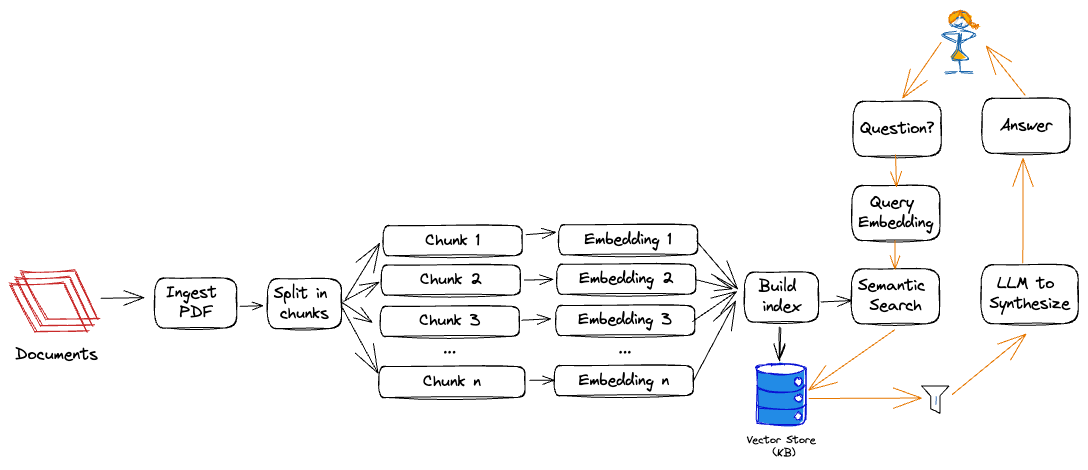

In [63]:
!pip install pypdf
!pip install google-cloud-storage

In [64]:
from google.cloud import storage

bucket_name = 'kevin-pdf-docs'    # 서비스 계정 생성한 bucket 이름 입력
source_blob_name = 'manage car.pdf'    # GCP에 저장되어 있는 파일 명
destination_file_name = 'manage car.pdf'    # 다운받을 파일을 저장할 경로("local/path/to/file")

storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(source_blob_name)

blob.download_to_filename(destination_file_name)

In [65]:
from langchain.document_loaders import PyPDFLoader

# PDF load
#url = "https://storage.cloud.google.com/kevin-pdf-docs/manage%20car.pdf"
loader = PyPDFLoader(destination_file_name)
documents = loader.load()

In [66]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=0)
docs = text_splitter.split_documents(documents)
print(f"# of documents = {len(docs)}")

# of documents = 11


In [67]:
embeddings

CustomVertexAIEmbeddings(project=None, location='us-central1', request_parallelism=5, max_retries=6, stop=None, model_name='textembedding-gecko', client=<vertexai.preview.language_models._PreviewTextEmbeddingModel object at 0x7a35536652a0>, temperature=0.0, max_output_tokens=128, top_p=0.95, top_k=40, credentials=None, requests_per_minute=100, num_instances_per_batch=5)

Store docs in local vectorstore as index
it may take a while since API is rate limited

In [68]:
from langchain.vectorstores import Chroma
db = Chroma.from_documents(docs, embeddings)

Waiting
..

In [69]:
# Expose index to the retriever
retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": 2})

In [70]:
# Create chain to answer questions
from langchain.chains import RetrievalQA

# Uses LLM to synthesize results from the search index.
# We use Vertex PaLM Text API for LLM
qa = RetrievalQA.from_chain_type(
    llm=llm, chain_type="stuff", retriever=retriever, return_source_documents=True
)

In [74]:
query = "의전차량 배차 기준은?"
result = qa({"query": query})
print(result)

{'query': '의전차량 배차 기준은?', 'result': '의전 차량 배차는 국내외 외빈수송과 임원이상 배차로 제한한다.', 'source_documents': [Document(page_content='㈜하림지주  Harim Holdings  Co., L td 4 쪽 \n 이상 반복적으로 발생하거나  상태가  불량하여  수리비용이  과다 발생할  수 있는 경우 \n(3) 임차 차량의  계약기간  종료 시 \n(4) 차량사고  및 특수한  사정에  의하여  매각 또는 폐기하여야  할 경우 \n(5) 기타 차량 교체의  필요성이  인정될  경우 \n \n2. 교체된  차량은  매각함을  원칙으로  하며 매각이  불가능한  경우는  폐차한다 . \n \n3. 차량 매각은  관리부서 에서 정식허가  된 외부 중고차량  매매 업체의  \n견적(복수견적 )을 비교하여  처리함을  원칙으로  한다. \n \n제7조 (차량 제공 기준 등) \n \n1. 전용 차량 제공 및 수행기사  배정은  경영진의  직위 등을 고려하여  별도의  정하는  \n바에 따르며  전용차량은  별도의  배차 신청 없이 각종 업무수행  및 출퇴근  지원을  한다. \n \n2. 의전 차량 배차는  국내외  외빈수송과  임원이상  배차로  제한한다 . \n \n3. 업무 차량의  사용 목적은  외근, 행사 동원, 고객 응대 등의 업무 용도로  제한함을  \n원칙으로  한다. \n \n4. 임∙직원에  대한 차량 지원 및 업무와  관련한  교통비  등은 제반 환경을  고려하여  \n별도로  정하는  방식에  따라 지원할  수 있다. \n \n5. 전용 차량 및 의전 차량은  배기량  2,400cc 급의 차종으로  제공하며 , 제공 받는 \n경영진의  선택에  따라 차량을  정한다 . 다만, 경영진의  직위, 위임 받은 업무의  성격, \n업무 난이도 , 업무 수행 지역, 업무 상대방의  지위, 위임계약  체결시  정한 조건 등 \n제반 사정을  고려하여  2,400cc 급 이상 6,000cc 